In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 📦 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# 8호선 모델 불러와서 테스트

In [4]:
df = pd.read_parquet('/content/drive/MyDrive/DL/prepro_data.parquet')

df2 = df[df['호선'] == 8].copy()

cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df2[col] = df2[col].astype('category')

# 시 (0~23 기준)
df2['시_sin'] = np.sin(2 * np.pi * df2['시'] / 24)
df2['시_cos'] = np.cos(2 * np.pi * df2['시'] / 24)

# 요일 (0~6 기준, 월~일)
df2['요일_sin'] = np.sin(2 * np.pi * df2['요일'] / 7)
df2['요일_cos'] = np.cos(2 * np.pi * df2['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df['월'] = le.fit_transform(df['월'])
df['일'] = le.fit_transform(df['일'])

# 1. float64 → float32
float_cols = df2.select_dtypes(include=['float64']).columns
df2[float_cols] = df2[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df2.select_dtypes(include=['int64']).columns
df2[int_cols] = df2[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df2.select_dtypes(include=['object']).columns
df2[obj_cols] = df2[obj_cols].astype('category')

df2 = df2.drop(['시', '요일'], axis=1)
df2.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df2.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)
# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df2[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------

# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21
batch_size = 32

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_line8 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_line8.compile(loss='mse', optimizer=Adam(0.001))


# 모델 저장 경로 지정 (예: MyDrive/models 폴더)
save_path = '/content/drive/MyDrive/models/Line8_best_model.weights.h5'

# 콜백 설정
callbacks = [
    ModelCheckpoint(filepath=save_path,
        monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
]



<class 'pandas.core.frame.DataFrame'>
Index: 771922 entries, 5094180 to 15653609
Data columns (total 27 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   시간        771922 non-null  datetime64[ns]
 1   호선        771922 non-null  category      
 2   역번호       771922 non-null  int32         
 3   역명        771922 non-null  category      
 4   상하구분      771922 non-null  category      
 5   AWS지점코드   771922 non-null  category      
 6   기온        771922 non-null  float32       
 7   풍향        771922 non-null  float32       
 8   풍속        771922 non-null  float32       
 9   일강수량      771922 non-null  float32       
 10  시간강수량     771922 non-null  float32       
 11  상대습도      771922 non-null  float32       
 12  체감온도      771922 non-null  float32       
 13  혼잡도       771922 non-null  float32       
 14  승차총승객수    771922 non-null  float32       
 15  하차총승객수    771922 non-null  float32       
 16  미세먼지      771922 non-null  float32 

In [5]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------

# 최고 성능의 가중치 로드
model_line8.load_weights(save_path)

# 검증셋에 대해 예측 수행
pred_scaled = model_line8.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred = ss.inverse_transform(pred_scaled)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

# 평가 지표 계산
mse = mean_squared_error(true, pred)
rmse = np.sqrt(mse)
r2 = r2_score(true, pred)                       # R² Score

# 결과 출력
print(f"✅ 검증 RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
✅ 검증 RMSE: 3.5443
✅ R² Score: 0.9716


In [6]:
val_times = df2.iloc[split_index:]['시간']
val_time_list = val_times.tolist()

# 예시: 앞 5개만 출력해보기
print("✅ 검증 데이터 시간 리스트 (예시 앞 n개):")
print(val_time_list[:100])


✅ 검증 데이터 시간 리스트 (예시 앞 n개):
[Timestamp('2023-07-23 19:00:00'), Timestamp('2023-07-23 20:00:00'), Timestamp('2023-07-23 21:00:00'), Timestamp('2023-07-23 22:00:00'), Timestamp('2023-07-23 23:00:00'), Timestamp('2023-07-24 00:00:00'), Timestamp('2023-07-24 01:00:00'), Timestamp('2023-07-24 05:00:00'), Timestamp('2023-07-24 06:00:00'), Timestamp('2023-07-24 07:00:00'), Timestamp('2023-07-24 08:00:00'), Timestamp('2023-07-24 09:00:00'), Timestamp('2023-07-24 15:00:00'), Timestamp('2023-07-24 16:00:00'), Timestamp('2023-07-24 17:00:00'), Timestamp('2023-07-24 18:00:00'), Timestamp('2023-07-24 19:00:00'), Timestamp('2023-07-24 20:00:00'), Timestamp('2023-07-24 21:00:00'), Timestamp('2023-07-24 22:00:00'), Timestamp('2023-07-24 23:00:00'), Timestamp('2023-07-25 00:00:00'), Timestamp('2023-07-25 01:00:00'), Timestamp('2023-07-25 05:00:00'), Timestamp('2023-07-25 06:00:00'), Timestamp('2023-07-25 07:00:00'), Timestamp('2023-07-25 08:00:00'), Timestamp('2023-07-25 09:00:00'), Timestamp('2023-07-2

In [89]:
# 시계열 길이 고려된 시간 인덱스
val_start_index = split_index + sequence_length
time_for_val = df2.iloc[val_start_index:]['시간'].reset_index(drop=True)

# 실제값 복원
true_val = ss.inverse_transform(val_y[sequence_length:])

# 예측값 복원
pred_scaled = model_line8.predict(val_gen)
pred_val = ss.inverse_transform(pred_scaled)

import pandas as pd

# 예측 결과 + 시간 합치기
result_df = pd.DataFrame({
    '시간': time_for_val,
    '실제 혼잡도': true_val.flatten(),
    '예측 혼잡도': pred_val.flatten()
})

# 앞부분 확인
print(result_df.head())

4824/4824 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step
                   시간  실제 혼잡도     예측 혼잡도
0 2023-07-25 00:00:00    12.0  11.480143
1 2023-07-25 01:00:00     2.0   2.041201
2 2023-07-25 05:00:00    27.0  27.862040
3 2023-07-25 06:00:00    41.0  42.782806
4 2023-07-25 07:00:00    79.0  81.259621


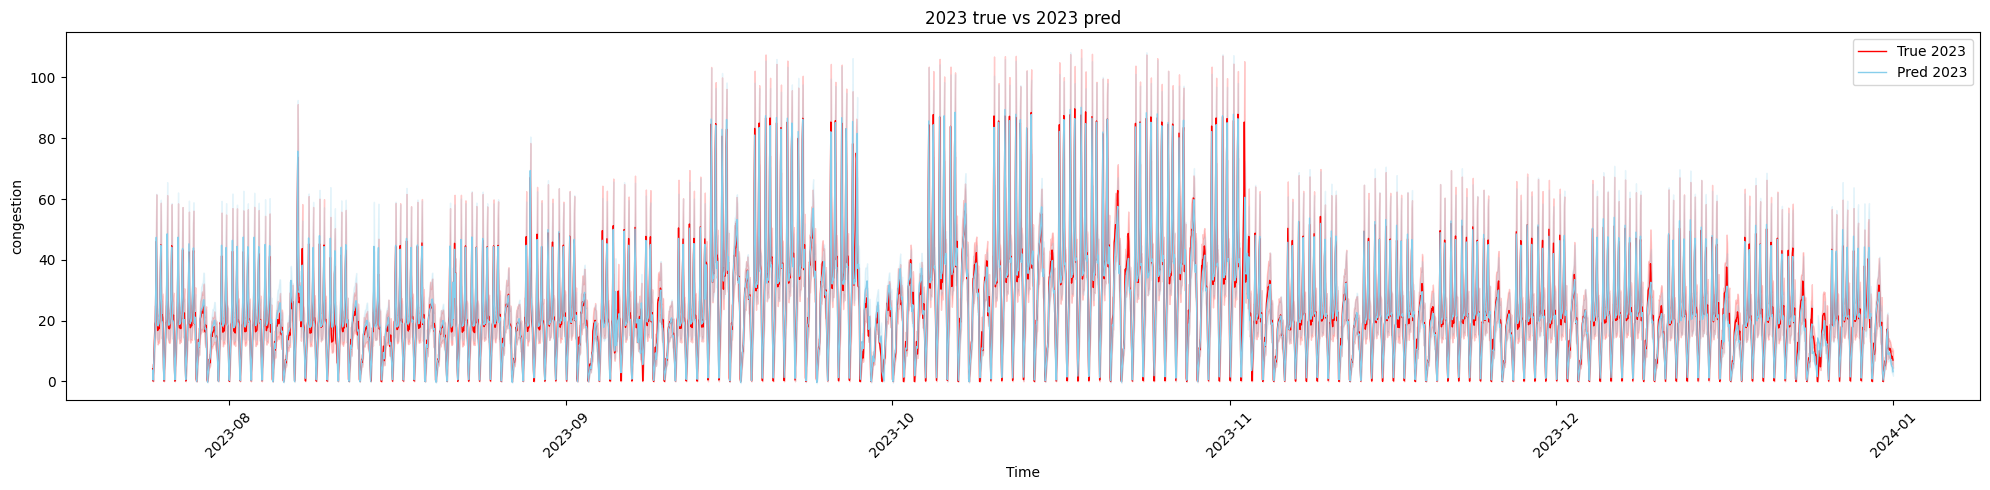

In [ ]:
df_시각화_2023 = result_df[result_df['시간'] >= pd.to_datetime('2023-07-25')].copy()

plt.figure(figsize=(20, 5))

sns.lineplot(x=df_시각화_2023['시간'], y=df_시각화_2023['실제 혼잡도'], label='True 2023', color='red', linewidth=1)
sns.lineplot(x=df_시각화_2023['시간'], y=df_시각화_2023['예측 혼잡도'], label='Pred 2023', color='skyblue', linewidth=1)

plt.xlabel('Time')
plt.ylabel('congestion')
plt.title('2023 true vs 2023 pred')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

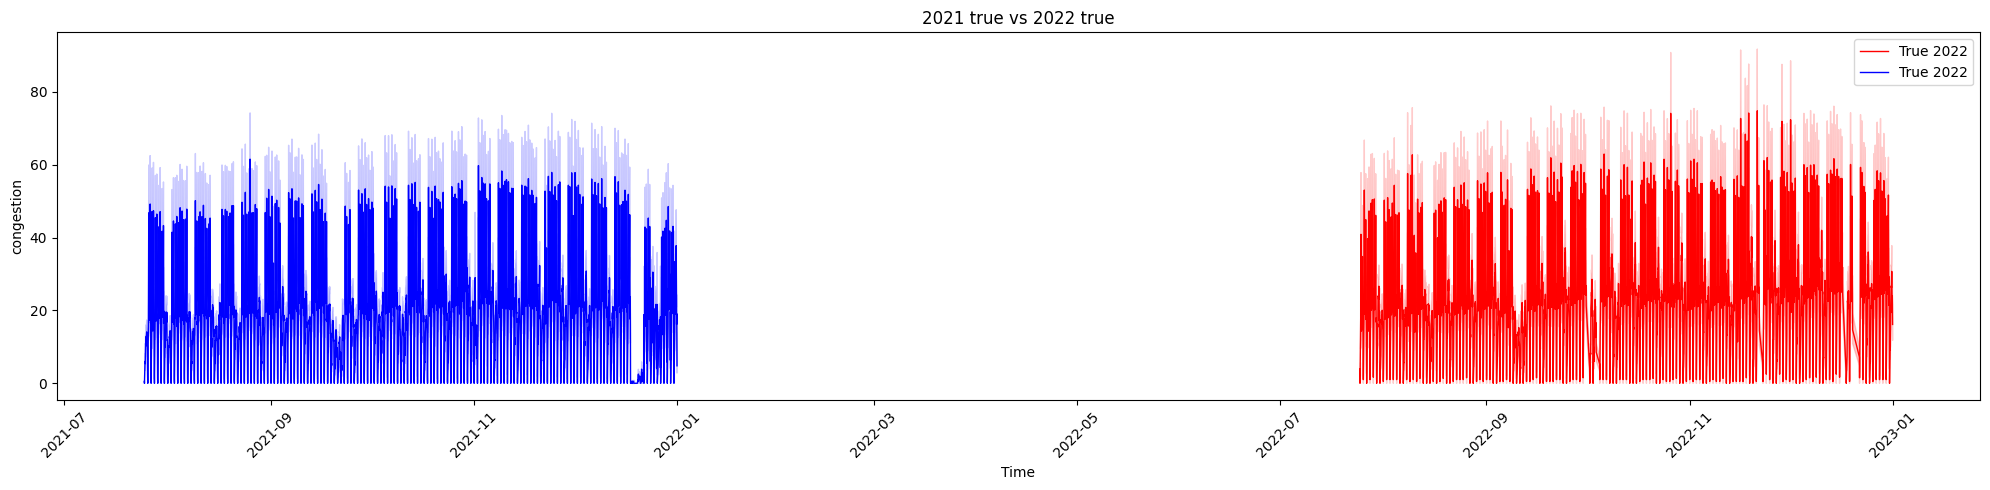

In [75]:
df_2022 = df[(df['시간']>= '2022-07-25 00:00:00')&(df['시간']<= '2022-12-31 23:00:00')&(df['호선']==8)][['시간','혼잡도']]
df_2021 = df[(df['시간']>= '2021-07-25 00:00:00')&(df['시간']<= '2021-12-31 23:00:00')&(df['호선']==8)][['시간','혼잡도']]

df_2021 = df_2021.drop_duplicates().reset_index(drop=True)
df_2022 = df_2022.drop_duplicates().reset_index(drop=True)


plt.figure(figsize=(20, 5))

sns.lineplot(x=df_2022['시간'], y=df_2022['혼잡도'], label='True 2022', color='red', linewidth=1)
sns.lineplot(x=df_2021['시간'], y=df_2021['혼잡도'], label='True 2022', color='blue', linewidth=1)

plt.xlabel('Time')
plt.ylabel('congestion')
plt.title('2021 true vs 2022 true')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

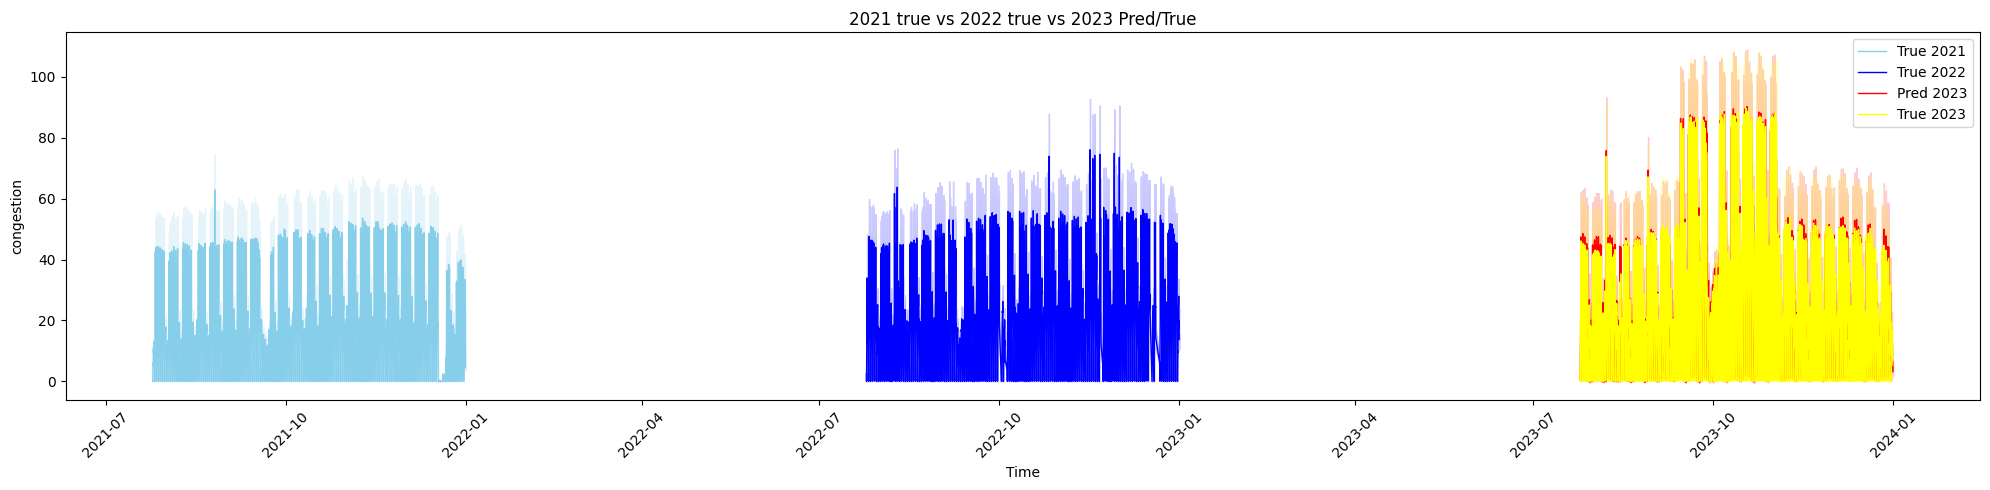

In [90]:
df_2022 = df[(df['시간']>= '2022-07-25 00:00:00')&(df['시간']<= '2022-12-31 23:00:00')&(df['호선']==8)][['시간','혼잡도']]
df_2021 = df[(df['시간']>= '2021-07-25 00:00:00')&(df['시간']<= '2021-12-31 23:00:00')&(df['호선']==8)][['시간','혼잡도']]
df_2022 = df_2022.sort_values(by='시간')
df_2021 = df_2021.sort_values(by='시간')
result_df = result_df.sort_values(by='시간')
result_df = result_df[(result_df['시간']>= '2023-07-25 00:00:00')&(result_df['시간']<= '2023-12-31 23:00:00')]

plt.figure(figsize=(20, 5))

sns.lineplot(x=df_2021['시간'], y=df_2021['혼잡도'], label='True 2021', color='skyblue', linewidth=1)
sns.lineplot(x=df_2022['시간'], y=df_2022['혼잡도'], label='True 2022', color='blue', linewidth=1)
sns.lineplot(x=result_df['시간'], y=result_df['예측 혼잡도'], label='Pred 2023', color='red', linewidth=1)
sns.lineplot(x=result_df['시간'], y=result_df['실제 혼잡도'], label='True 2023', color='yellow', linewidth=1)

plt.xlabel('Time')
plt.ylabel('congestion')
plt.title('2021 true vs 2022 true vs 2023 Pred/True')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

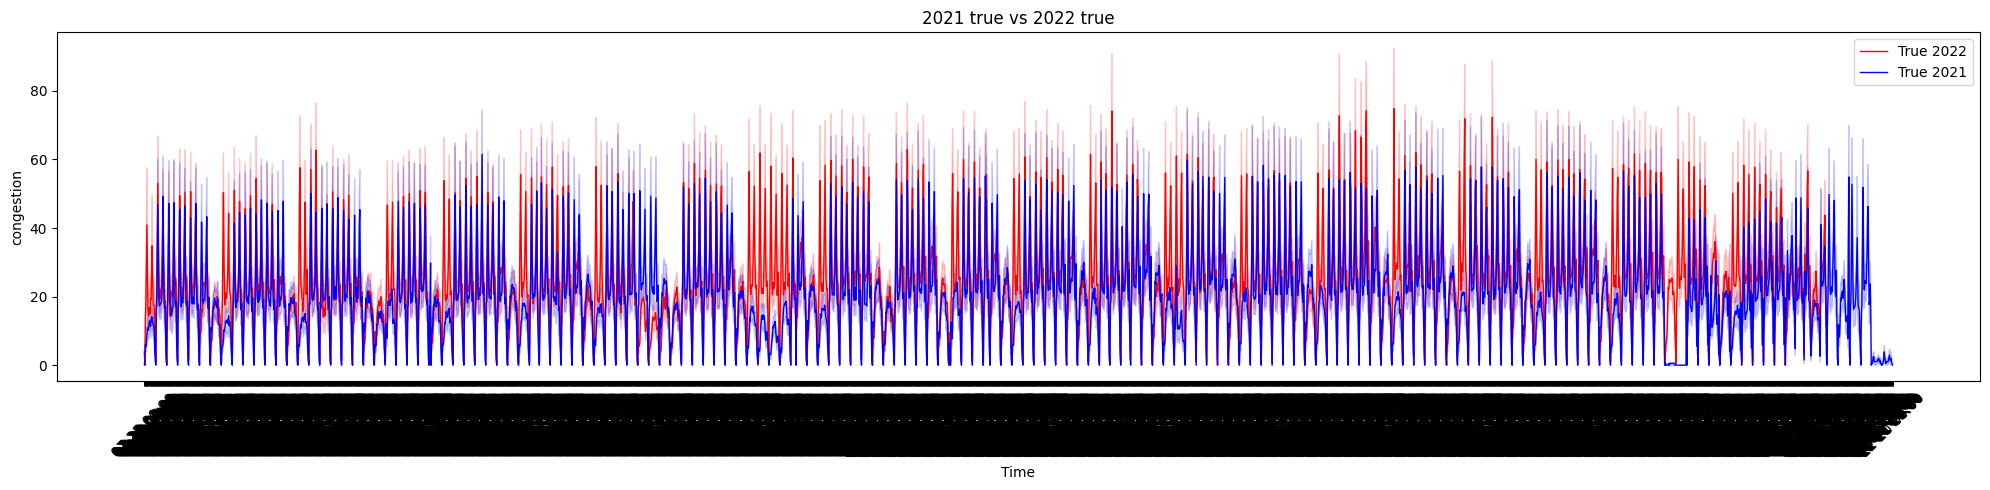

In [77]:
df_2022 = df[(df['시간']>= '2022-07-25 00:00:00')&(df['시간']<= '2022-12-31 23:00:00')&(df['호선']==8)][['시간','혼잡도']]
df_2021 = df[(df['시간']>= '2021-07-25 00:00:00')&(df['시간']<= '2021-12-31 23:00:00')&(df['호선']==8)][['시간','혼잡도']]

df_2021 = df_2021.drop_duplicates().reset_index(drop=True)
df_2022 = df_2022.drop_duplicates().reset_index(drop=True)

df_2021['시간'] = df_2021['시간'].dt.strftime('%m-%d %H:%M')
df_2022['시간'] = df_2022['시간'].dt.strftime('%m-%d %H:%M')

plt.figure(figsize=(20, 5))

sns.lineplot(x=df_2022['시간'], y=df_2022['혼잡도'], label='True 2022', color='red', linewidth=1)
sns.lineplot(x=df_2021['시간'], y=df_2021['혼잡도'], label='True 2021', color='blue', linewidth=1)

plt.xlabel('Time')
plt.ylabel('congestion')
plt.title('2021 true vs 2022 true')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 7호선

In [ ]:
# 📁 데이터 불러오기
df = pd.read_parquet('/content/drive/MyDrive/DL/prepro_data.parquet')
df1 = df[df['호선'] == 7].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df1[col] = df1[col].astype('category')

# 시 (0~23 기준)
df1['시_sin'] = np.sin(2 * np.pi * df1['시'] / 24)
df1['시_cos'] = np.cos(2 * np.pi * df1['시'] / 24)

# 요일 (0~6 기준, 월~일)
df1['요일_sin'] = np.sin(2 * np.pi * df1['요일'] / 7)
df1['요일_cos'] = np.cos(2 * np.pi * df1['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df['월'] = le.fit_transform(df['월'])
df['일'] = le.fit_transform(df['일'])

# 1. float64 → float32
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df1.select_dtypes(include=['object']).columns
df1[obj_cols] = df1[obj_cols].astype('category')

df1 = df1.drop(['시', '요일'], axis=1)
df1.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df1.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df1[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------

# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21
batch_size = 32

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model.compile(loss='mse', optimizer=Adam(0.001))

<class 'pandas.core.frame.DataFrame'>
Index: 1988708 entries, 4327680 to 15378425
Data columns (total 27 columns):
 #   Column    Dtype         
---  ------    -----         
 0   시간        datetime64[ns]
 1   호선        category      
 2   역번호       int32         
 3   역명        category      
 4   상하구분      category      
 5   AWS지점코드   category      
 6   기온        float32       
 7   풍향        float32       
 8   풍속        float32       
 9   일강수량      float32       
 10  시간강수량     float32       
 11  상대습도      float32       
 12  체감온도      float32       
 13  혼잡도       float32       
 14  승차총승객수    float32       
 15  하차총승객수    float32       
 16  미세먼지      float32       
 17  연도        category      
 18  월         int32         
 19  일         int32         
 20  주말        int32         
 21  공휴일       int32         
 22  일사량_측정여부  int32         
 23  시_sin     float32       
 24  시_cos     float32       
 25  요일_sin    float32       
 26  요일_cos    float32       
dtypes: categor

In [ ]:
# 모델 저장 경로 지정 (예: MyDrive/models 폴더)
save_path = '/content/drive/MyDrive/models/Line7_best_model.weights.h5'

# 콜백 설정
callbacks = [
    ModelCheckpoint(filepath=save_path,
        monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
]

# 모델 학습
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

In [ ]:
# 2) 이전에 저장한 가중치 로드
save_path = '/content/drive/MyDrive/models/Line7_best_model.weights.h5'
model.load_weights(save_path)

callbacks = [
    ModelCheckpoint(filepath=save_path,
        monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
]


# 3) 이어서 학습
history_additional = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,           # 총 학습 에폭 수
    initial_epoch=21,    # 이어서 시작할 에폭
    callbacks=callbacks
)

Epoch 22/50
49711/49718 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0279
Epoch 22: val_loss improved from inf to 0.05190, saving model to /content/drive/MyDrive/models/Line7_best_model.weights.h5
49718/49718 ━━━━━━━━━━━━━━━━━━━━ 365s 7ms/step - loss: 0.0279 - val_loss: 0.0519 - learning_rate: 5.0000e-04
Epoch 23/50
49716/49718 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0281
Epoch 23: val_loss improved from 0.05190 to 0.05092, saving model to /content/drive/MyDrive/models/Line7_best_model.weights.h5
49718/49718 ━━━━━━━━━━━━━━━━━━━━ 366s 7ms/step - loss: 0.0281 - val_loss: 0.0509 - learning_rate: 5.0000e-04
Epoch 24/50
49714/49718 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0277
Epoch 24: val_loss improved from 0.05092 to 0.04935, saving model to /content/drive/MyDrive/models/Line7_best_model.weights.h5
49718/49718 ━━━━━━━━━━━━━━━━━━━━ 367s 7ms/step - loss: 0.0277 - val_loss: 0.0493 - learning_rate: 5.0000e-04
Epoch 25/50
49713/49718 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0276
Epoch 25

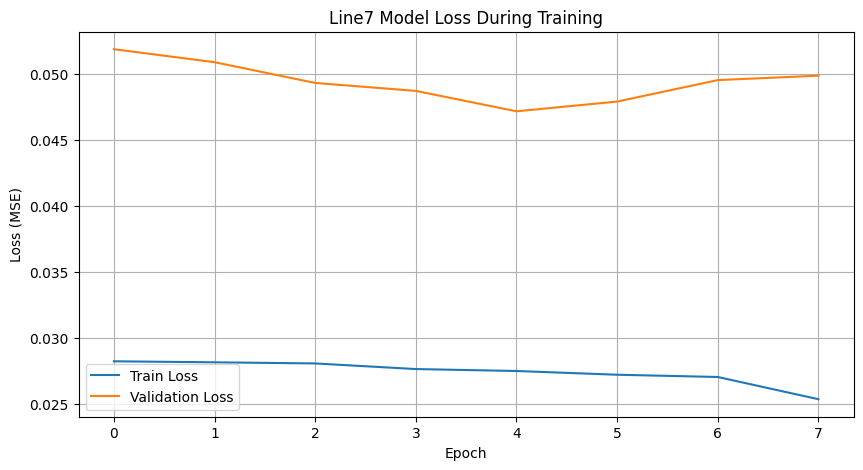

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_additional.history['loss'], label='Train Loss')
plt.plot(history_additional.history['val_loss'], label='Validation Loss')
plt.title('Line7 Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# 최고 성능의 가중치 로드
model.load_weights(save_path)

# 검증셋에 대해 예측 수행
pred_scaled = model.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred = ss.inverse_transform(pred_scaled)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

# 평가 지표 계산
mse = mean_squared_error(true, pred)
rmse = np.sqrt(mse)
r2 = r2_score(true, pred)

# 결과 출력
print(f"✅ 검증 RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")


12429/12429 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step
✅ 검증 RMSE: 4.6183
✅ R² Score: 0.9617


# 8호선

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/DL/prepro_data.parquet')
df2 = df[df['호선'] == 8].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df2[col] = df2[col].astype('category')

# 시 (0~23 기준)
df2['시_sin'] = np.sin(2 * np.pi * df2['시'] / 24)
df2['시_cos'] = np.cos(2 * np.pi * df2['시'] / 24)

# 요일 (0~6 기준, 월~일)
df2['요일_sin'] = np.sin(2 * np.pi * df2['요일'] / 7)
df2['요일_cos'] = np.cos(2 * np.pi * df2['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df['월'] = le.fit_transform(df['월'])
df['일'] = le.fit_transform(df['일'])

# 1. float64 → float32
float_cols = df2.select_dtypes(include=['float64']).columns
df2[float_cols] = df2[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df2.select_dtypes(include=['int64']).columns
df2[int_cols] = df2[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df2.select_dtypes(include=['object']).columns
df2[obj_cols] = df2[obj_cols].astype('category')

df2 = df2.drop(['시', '요일'], axis=1)
df2.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df2.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df2[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------

# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21
batch_size = 32

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_line8 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_line8.compile(loss='mse', optimizer=Adam(0.001))


# 모델 저장 경로 지정 (예: MyDrive/models 폴더)
save_path = '/content/drive/MyDrive/models/Line8_best_model.weights.h5'

# 콜백 설정
callbacks = [
    ModelCheckpoint(filepath=save_path,
        monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
]

# 모델 학습
history_line8 = model_line8.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

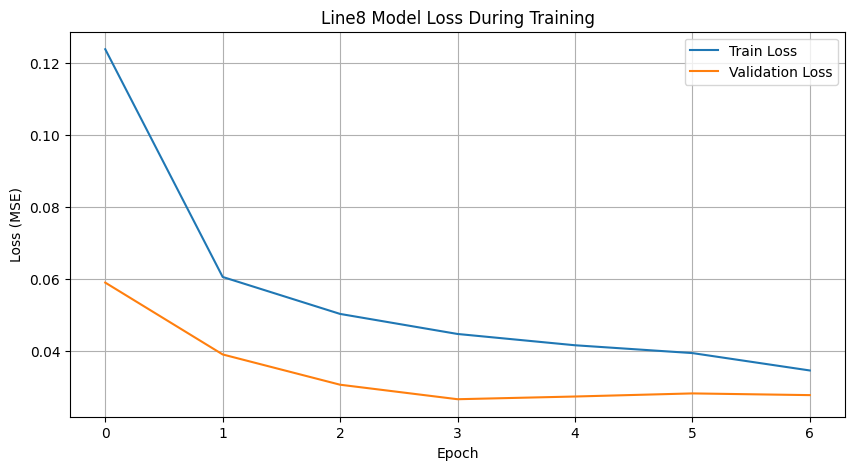

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_line8.history['loss'], label='Train Loss')
plt.plot(history_line8.history['val_loss'], label='Validation Loss')
plt.title('Line8 Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()